In [1]:
## Init Bionic VTOL

include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode

create_visualization();

# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


1

In [2]:
## Create Reinforcement Learning Environment

mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environments
    visualization::Bool # visualization
    realtime::Bool # realtime

    x_previous::Vector{T} # previous position
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    ω_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    Δt::T # simulation time step

    ################################ TODO ################################
    # Extend the environment here.
    # Everything you need additionaly in your environment also go in here.
    # E.g. a trajectory

    waypoints::Vector{Vector{T}} # waypoints
    proximity_tolerance::T # proximity tolerance
    max_v::T # maximum allowed velocity

    ######################################################################
end

################################ TODO ################################
# You can initialization global constants here.
# E.g. a fixed point in the beginning of training (for testing/overfitting)
# Define global constants for initial position and rotation
const INITIAL_POSITION = [0.0, 0.0, 0.0];
const INITIAL_ROTATION = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0];
const SAMPLE_WAYPOINTS = [[35.0, 0.0, 20.0], [-7.0, 0.0, 4.0]]
######################################################################


2-element Vector{Vector{Float64}}:
 [35.0, 0.0, 20.0]
 [-7.0, 0.0, 4.0]

In [3]:
# define a keyword-based constructor for the type declared in the mutable struct typedef.
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs...) # let the function take an arbitrary number of keyword arguments
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    A = Space{Vector{ClosedInterval{T}}};

    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ],
    ) # propeller 1 and 2
    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            ################################ TODO ################################
            # Implement an observation space. 
            # Here is an example space. You can change it if desired.
            # You have to extend it.
            # Orientate yourself on the observation space from the paper.
            
            typemin(T)..typemax(T), # previous position along x WORLD coordinates
            typemin(T)..typemax(T), # previous position along z WORLD coordinates

            typemin(T)..typemax(T), # current position along x WORLD coordinates
            typemin(T)..typemax(T), # current position along z WORLD coordinates
            
            typemin(T)..typemax(T), # orientation along x WORLD coordinates
            typemin(T)..typemax(T), # orientation along z WORLD coordinates
            
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates

            typemin(T)..typemax(T), # position of target along x WORLD coordinates
            typemin(T)..typemax(T), # position of target along y WORLD coordinates

            ######################################################################
            ], 
    )
    
    if visualization #visualizes VTOL
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
    end

    environment = VtolEnv(
        action_space, # action space
        state_space, # observation space
        zeros(T, length(state_space)), # current state space
        rand(action_space), # initialization action
        false, # episode done 
        0.0, # time
        rng, # random number generator  
        
        name,
        visualization,
        realtime,
        
        zeros(T, 3), # x_previous, previous position
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation, Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # simulation time step

        ################################## TODO ##################################
        # Initialization everything you need additionaly in your environment here.
        SAMPLE_WAYPOINTS,
        1e-5, # proximity tolerance
        100.0, # maximum allowed velocity
        
        ##########################################################################
    )

    reset!(environment)
    return environment
end;

methods(VtolEnv)


# Just for explanation:
# 1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
# 2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.'
# So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at In[3]:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_previous::Vector{T}, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, waypoints::Array{Vector{T}, 1}, proximity_tolerance::T, max_v::T) where {A, T, ACT, R<:AbstractRNG} in Main at In[2]:4

In [4]:
## Define the RL interface

Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

global k_p = 5.0;
global k_w = 0.01;
global k_wp = 5.0;
function computeReward(env::VtolEnv{A,T}) where {A,T}
    reward = 0.0

    ################################ TODO ################################
    # Implement the reward function.
    # Orientate on the paper.
    gates = env.waypoints;
    n = length(gates);

    function compute_distance(position::Vector{T})
        l_min_index, phi_l = calculate_progress(gates, position);
        reached_distance = 0.0;
        for i in 1:(l_min_index-1)
            reached_distance += (norm(gates[i+1] - gates[i]) + norm(phi_l - gates[l]));
        end
        return reached_distance;
    end
    s_pt1 = compute_distance(env.x_previous);
    s_pt = compute_distance(env.x_W);
    r_pt = s_pt - s_pt1;

    function compute_ks()
        factor = 2 * env.Δt * env.max_v;
        sum = 0.0;
        for i in 1:(n-1)
            sum += norm(gates[i+1] - gates[i]);
        end
        return factor / sum;
    end
    k_s = compute_ks();

    r_t = 0; # no obstacles
    r_wp = 0 # for now no additional waypoints
    w = norm(env.ω_B);

    reward = k_p * r_pt + k_s * s_pt + k_wp * r_wp + r_t - k_w * w;
    ################################################################################################

    return reward
end

RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end

    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));

    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];

    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;

    ################################ TODO ################################
    # Reset environment.
    # Is called if the training terminates
    # (e.g. if drone crashes or successfully reaches point)
    # HINT: Everything you added to your environment needs to be reseted.
    #       Compare it with the initialization.

    env.x_previous = [0.0; 0.0; 0.0]; # starting position
    env.Δt = T(0.025); # Δ time

    env.waypoints = generate_trajectory(2);
    env.proximity_tolerance = 1e-5;
    ######################################################################

    nothing
end;

# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # set the propeller trust and the two flaps 2D case
    # flaps set to 0.0
    next_action = [a[1], a[2], 0.0, 0.0]

    _step!(env, next_action)
end

In [5]:
env = VtolEnv();
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[4]:92
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [6]:
function _step!(env::VtolEnv, next_action)

    ################################ TODO ################################
    # Implement step.
    # HINT: This is relatet to your environment.
    #       Compare to struct VtolEnv.
    #       How does it change in every step.

    env.state[1] = env.state[3]; # update previous x-coordinate
    env.state[2] = env.state[4]; # update previous z-coordinate
    env.x_previous = env.x_W;

    ######################################################################

    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W);

    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);

    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0;
    torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0;
    env.ω_B[2] = 0.0;

    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param);

    if env.realtime
        sleep(env.Δt); # just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action);
    end

    env.t += env.Δt

    env.state[3] = env.x_W[1]; # position along x
    env.state[4] = env.x_W[3]; # position along z

    env.state[5] = env.R_W[1,1]; # orientation along x
    env.state[6] = env.R_W[3,1]; # orientation along z

    env.state[7] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[8] = env.v_B[2]; # velocity along y BODY coordinates

    env.state[9] = env.ω_B[3];  # rotational velocity along z BODY coordinates

    ################################ TODO ################################
    # Implement step.
    # HINT: This is relatet to your environment.
    #       Compare to struct VtolEnv.
    #       How does it change in every step.

    env.state[10] = env.waypoints[1][1] - env.x_W[1] # position of target along x WORLD coordinates
    env.state[11] = env.waypoints[1][3] - env.x_W[3] # position of target along z WORLD coordinates
    ######################################################################


    ################################ TODO ################################
    # Add termination criterias.
    # Use many termination criteria so that you do not train unnecessarily in wrong areas.
    env.done =
        norm(env.ω_B) > 100.0 || # stop if body rate is too high
        norm(env.v_B) > env.max_v || # stop if body is too fast
        norm(env.waypoints[1] - env.x_W) < env.proximity_tolerance# target reached
    ######################################################################

    nothing
end;

RLBase.test_runnable!(env)

# changed to 10s (5s before) per point and 5.0m too far off path (2.0 before)
# Show an overview of the environment.

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  1.1s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.674726897430627e9, 1.674726898503099e9)

In [7]:
## Setup of a reinforcement learning experiment.

seed = 123
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024

    vtol_envs = [
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ];
    # define multiple environments for parallel training
    env = MultiThreadEnv(vtol_envs)

    # Define the function approximator
    # (optional) TODO: change architecture
    # TODO: research briefly what Actor Critic is
    # (optional) TODO: change optimizer
    # TODO: research what ADAM is
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 16, tanh; initW = glorot_uniform(rng)),#
                    Dense(16, 16, tanh; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 16, tanh; initW = glorot_uniform(rng)),
                    Dense(16, 16, tanh; initW = glorot_uniform(rng)),
                    Dense(16, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

        agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # (optional) TODO: change eventually
        # TODO: research briefly what PPO is
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),

        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


┌ Info: The GPU function is being called but the GPU is not accessible. 
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).


In [8]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./RL_models/", "vtol_2D_ppo_$t.bson") # TODO: save model here
    @save f model
    println("parameters at step $t saved to $f")
end;

function loadModel()
    f = joinpath("./RL_models/", "vtol_2D_ppo_1500000.bson") # TODO: load model here
    @load f model
    return model
end;

function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")

end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

# agent.policy.approximator = loadModel();

In [9]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(1_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000), 
        DoEveryNStep(validate_policy, n=10_000)),
)

Progress:   0%|                                         |  ETA: 11:55:509m

test reward at step 10000: -50.27478665362884


Progress:   1%|▌                                        |  ETA: 0:53:54

test reward at step 20000: -45.72909637124421


Progress:   2%|▊                                        |  ETA: 0:36:44

test reward at step 30000: -42.665619303186496


Progress:   3%|█▏                                       |  ETA: 0:31:25

test reward at step 40000: -45.324463221226


Progress:   3%|█▎                                       |  ETA: 0:27:16

test reward at step 50000: -41.97500529008495


Progress:   4%|█▋                                       |  ETA: 0:24:22

test reward at step 60000: -46.571899335792686


Progress:   5%|█▉                                       |  ETA: 0:22:17

test reward at step 70000: -52.70711554473564


Progress:   5%|██                                       |  ETA: 0:22:59

test reward at step 80000: -45.54430806780489


Progress:   6%|██▍                                      |  ETA: 0:21:18

test reward at step 90000: -51.3644877061217


Progress:   6%|██▋                                      |  ETA: 0:22:06

parameters at step 100000 saved to ./RL_models/vtol_2D_ppo_100000.bson
test reward at step 100000: -59.15290286351076


Progress:   7%|██▉                                      |  ETA: 0:21:42

test reward at step 110000: -48.761153947328275


Progress:   8%|███▏                                     |  ETA: 0:21:52

test reward at step 120000: -41.61552775071217


Progress:   9%|███▌                                     |  ETA: 0:20:46

test reward at step 130000: -48.38351695796337


Progress:   9%|███▉                                     |  ETA: 0:20:00

test reward at step 140000: -40.76593698681828


Progress:  10%|████                                     |  ETA: 0:20:05

test reward at step 150000: -56.355446545898474


Progress:  11%|████▍                                    |  ETA: 0:19:45

test reward at step 160000: -45.58778709711167


Progress:  11%|████▌                                    |  ETA: 0:19:56

test reward at step 170000: -36.90304340299312


Progress:  12%|████▉                                    |  ETA: 0:19:16

test reward at step 180000: -41.112838029595


Progress:  13%|█████▏                                   |  ETA: 0:18:40

test reward at step 190000: -49.14753902228853


Progress:  13%|█████▍                                   |  ETA: 0:18:45

parameters at step 200000 saved to ./RL_models/vtol_2D_ppo_200000.bson
test reward at step 200000: -42.71605412576071


Progress:  14%|█████▋                                   |  ETA: 0:18:24

test reward at step 210000: -63.89094306647099


Progress:  15%|██████                                   |  ETA: 0:18:15

test reward at step 220000: -56.91880722666081


Progress:  15%|██████▎                                  |  ETA: 0:18:32

test reward at step 230000: -41.52158019000579


Progress:  16%|██████▌                                  |  ETA: 0:18:06

test reward at step 240000: -39.544196642336765


Progress:  16%|██████▊                                  |  ETA: 0:17:43

test reward at step 250000: -54.28467371255836


Progress:  17%|███████▏                                 |  ETA: 0:17:31

test reward at step 260000: -41.32903292994354


Progress:  18%|███████▎                                 |  ETA: 0:17:28

test reward at step 270000: -37.76508589776515


Progress:  18%|███████▋                                 |  ETA: 0:17:01

test reward at step 280000: -54.26100098313122


Progress:  19%|███████▉                                 |  ETA: 0:16:50

test reward at step 290000: -66.57751739262602


Progress:  20%|████████                                 |  ETA: 0:16:58

parameters at step 300000 saved to ./RL_models/vtol_2D_ppo_300000.bson
test reward at step 300000: -38.96873069231807


Progress:  20%|████████▍                                |  ETA: 0:16:34

test reward at step 310000: -64.37266374932545


Progress:  21%|████████▊                                |  ETA: 0:16:23

test reward at step 320000: -37.39950839480728


Progress:  22%|█████████                                |  ETA: 0:16:41

test reward at step 330000: -63.60065383975396


Progress:  22%|█████████▏                               |  ETA: 0:16:22

test reward at step 340000: -53.31580251582374


Progress:  23%|█████████▌                               |  ETA: 0:16:16

test reward at step 350000: -43.04387729097994


Progress:  24%|█████████▊                               |  ETA: 0:16:05

test reward at step 360000: -57.795397070401464


Progress:  25%|██████████▏                              |  ETA: 0:16:17

test reward at step 370000: -45.89490817529486


Progress:  25%|██████████▎                              |  ETA: 0:16:00

test reward at step 380000: -40.51217953277088


Progress:  26%|██████████▋                              |  ETA: 0:15:42

test reward at step 390000: -60.732307905191234


Progress:  26%|██████████▊                              |  ETA: 0:15:50

parameters at step 400000 saved to ./RL_models/vtol_2D_ppo_400000.bson
test reward at step 400000: -50.7151441235099


Progress:  27%|███████████▏                             |  ETA: 0:15:41

test reward at step 410000: -58.55582824309753


Progress:  28%|███████████▌                             |  ETA: 0:15:31

test reward at step 420000: -36.70584901348142


Progress:  28%|███████████▋                             |  ETA: 0:15:28

test reward at step 430000: -40.61745119610154


Progress:  29%|████████████                             |  ETA: 0:15:13

test reward at step 440000: -44.37809624066083


Progress:  30%|████████████▎                            |  ETA: 0:14:59

test reward at step 450000: -66.14595980485464


Progress:  30%|████████████▍                            |  ETA: 0:15:10

test reward at step 460000: -38.78766731239758


Progress:  31%|████████████▉                            |  ETA: 0:14:49

test reward at step 470000: -57.58311538278573


Progress:  32%|█████████████                            |  ETA: 0:14:52

test reward at step 480000: -55.15131824802601


Progress:  33%|█████████████▍                           |  ETA: 0:14:41

test reward at step 490000: -57.75341169978245


Progress:  33%|█████████████▌                           |  ETA: 0:14:46

parameters at step 500000 saved to ./RL_models/vtol_2D_ppo_500000.bson


Progress:  33%|█████████████▋                           |  ETA: 0:14:48

test reward at step 500000: -60.0951303405528


Progress:  34%|█████████████▉                           |  ETA: 0:14:33

test reward at step 510000: -56.2677253627292


Progress:  35%|██████████████▏                          |  ETA: 0:14:24

test reward at step 520000: -41.0265217219385


Progress:  35%|██████████████▍                          |  ETA: 0:14:22

test reward at step 530000: -41.777192861443595


Progress:  36%|██████████████▋                          |  ETA: 0:14:07

test reward at step 540000: -66.5650756085995


Progress:  37%|███████████████                          |  ETA: 0:13:56

test reward at step 550000: -54.72979030498178


Progress:  37%|███████████████▏                         |  ETA: 0:14:06

test reward at step 560000: -75.27466136806423


Progress:  38%|███████████████▌                         |  ETA: 0:13:55

test reward at step 570000: -94.41412869532019


Progress:  39%|███████████████▊                         |  ETA: 0:13:53

test reward at step 580000: -54.14733902521274


Progress:  39%|████████████████▏                        |  ETA: 0:13:57

test reward at step 590000: -80.16495435297732


Progress:  40%|████████████████▎                        |  ETA: 0:13:45

parameters at step 600000 saved to ./RL_models/vtol_2D_ppo_600000.bson
test reward at step 600000: -73.51555059872143


Progress:  41%|████████████████▋                        |  ETA: 0:13:35

test reward at step 610000: -55.96550795290538


Progress:  41%|█████████████████                        |  ETA: 0:13:48

test reward at step 620000: -75.19042561331905


Progress:  42%|█████████████████▏                       |  ETA: 0:13:36

test reward at step 630000: -69.23088040663544


Progress:  43%|█████████████████▌                       |  ETA: 0:13:27

test reward at step 640000: -46.40646122923053


Progress:  43%|█████████████████▋                       |  ETA: 0:13:32

test reward at step 650000: -95.39180839155037


Progress:  44%|██████████████████                       |  ETA: 0:13:22

test reward at step 660000: -77.67538814294701


Progress:  45%|██████████████████▎                      |  ETA: 0:13:14

test reward at step 670000: -67.61109480301322


Progress:  45%|██████████████████▍                      |  ETA: 0:13:20

test reward at step 680000: -46.35516156127385


Progress:  46%|██████████████████▊                      |  ETA: 0:13:10

test reward at step 690000: -28.215517037657925


Progress:  47%|███████████████████▏                     |  ETA: 0:13:01

parameters at step 700000 saved to ./RL_models/vtol_2D_ppo_700000.bson
test reward at step 700000: -53.96223963609493


Progress:  47%|███████████████████▍                     |  ETA: 0:13:08

test reward at step 710000: -20.763710341821984


Progress:  48%|███████████████████▋                     |  ETA: 0:12:57

test reward at step 720000: -49.329069756494334


Progress:  49%|███████████████████▉                     |  ETA: 0:12:49

test reward at step 730000: -148.64558851873298


Progress:  49%|████████████████████▏                    |  ETA: 0:12:51

test reward at step 740000: -24.64295813917705


Progress:  50%|████████████████████▍                    |  ETA: 0:12:41

test reward at step 750000: -16.613504858003836


Progress:  51%|████████████████████▊                    |  ETA: 0:12:31

test reward at step 760000: -34.68768157184957


Progress:  51%|████████████████████▉                    |  ETA: 0:12:33

test reward at step 770000: -127.672064188686


Progress:  52%|█████████████████████▎                   |  ETA: 0:12:26

test reward at step 780000: -25.37627783808094


Progress:  53%|█████████████████████▋                   |  ETA: 0:12:16

test reward at step 790000: -36.29644015498255


Progress:  53%|█████████████████████▊                   |  ETA: 0:12:15

parameters at step 800000 saved to ./RL_models/vtol_2D_ppo_800000.bson
test reward at step 800000: -78.35944133541152


Progress:  54%|██████████████████████▏                  |  ETA: 0:12:06

test reward at step 810000: -97.21283068303984


Progress:  55%|██████████████████████▍                  |  ETA: 0:11:56

test reward at step 820000: -101.4099173126895


Progress:  55%|██████████████████████▌                  |  ETA: 0:11:57

test reward at step 830000: -100.86908503035167


Progress:  56%|██████████████████████▉                  |  ETA: 0:11:50

test reward at step 840000: -142.95694600464066


Progress:  57%|███████████████████████▎                 |  ETA: 0:11:41

test reward at step 850000: -62.36601245671032


Progress:  57%|███████████████████████▍                 |  ETA: 0:11:41

test reward at step 860000: -40.17638402378117


Progress:  58%|███████████████████████▋                 |  ETA: 0:11:29

test reward at step 870000: -36.3876457929037


Progress:  59%|████████████████████████                 |  ETA: 0:11:19

test reward at step 880000: -40.48054513439533


Progress:  59%|████████████████████████▎                |  ETA: 0:11:20

test reward at step 890000: -30.909801536633925


Progress:  60%|████████████████████████▌                |  ETA: 0:11:09

parameters at step 900000 saved to ./RL_models/vtol_2D_ppo_900000.bson
test reward at step 900000: -41.95236418398319


Progress:  61%|████████████████████████▉                |  ETA: 0:11:01

test reward at step 910000: -32.8007289776613


Progress:  61%|█████████████████████████▏               |  ETA: 0:10:52

test reward at step 920000: -31.921678903256126


Progress:  62%|█████████████████████████▎               |  ETA: 0:10:52

test reward at step 930000: -24.6534601628189


Progress:  62%|█████████████████████████▋               |  ETA: 0:10:43

test reward at step 940000: -33.319661752552626


Progress:  63%|█████████████████████████▉               |  ETA: 0:10:33

test reward at step 950000: -37.73264745618545


Progress:  64%|██████████████████████████▎              |  ETA: 0:10:23

test reward at step 960000: -50.24704789818437


Progress:  65%|██████████████████████████▌              |  ETA: 0:10:11

test reward at step 970000: -144.46489242179524


Progress:  65%|██████████████████████████▋              |  ETA: 0:10:10

test reward at step 980000: -62.3105549810656


Progress:  66%|███████████████████████████              |  ETA: 0:09:57

test reward at step 990000: -43.8124426081122


Progress:  66%|███████████████████████████▎             |  ETA: 0:09:53

parameters at step 1000000 saved to ./RL_models/vtol_2D_ppo_1000000.bson
test reward at step 1000000: -36.423195552701024


Progress:  67%|███████████████████████████▌             |  ETA: 0:09:40

test reward at step 1010000: -38.98372542105567


Progress:  68%|███████████████████████████▉             |  ETA: 0:09:27

test reward at step 1020000: -53.79793434140324


Progress:  68%|████████████████████████████             |  ETA: 0:09:24

test reward at step 1030000: -50.746734782654414


Progress:  69%|████████████████████████████▍            |  ETA: 0:09:13

test reward at step 1040000: -93.50829640031576


Progress:  70%|████████████████████████████▋            |  ETA: 0:09:00

test reward at step 1050000: -41.991210404796185


Progress:  70%|████████████████████████████▉            |  ETA: 0:08:57

test reward at step 1060000: -41.6485728004321


Progress:  71%|█████████████████████████████▏           |  ETA: 0:08:43

test reward at step 1070000: -75.26139416914073


Progress:  72%|█████████████████████████████▌           |  ETA: 0:08:29

test reward at step 1080000: -60.664045963256406


Progress:  72%|█████████████████████████████▋           |  ETA: 0:08:24

test reward at step 1090000: -27.255111972282343


Progress:  73%|██████████████████████████████           |  ETA: 0:08:11

parameters at step 1100000 saved to ./RL_models/vtol_2D_ppo_1100000.bson
test reward at step 1100000: -10.88137253665415


Progress:  74%|██████████████████████████████▍          |  ETA: 0:07:56

test reward at step 1110000: -30.079675434089506


Progress:  74%|██████████████████████████████▌          |  ETA: 0:07:53

test reward at step 1120000: -94.22128405822103


Progress:  75%|██████████████████████████████▉          |  ETA: 0:07:39

test reward at step 1130000: -80.57152550354046


Progress:  76%|███████████████████████████████▏         |  ETA: 0:07:25

test reward at step 1140000: -38.75345325847724


Progress:  76%|███████████████████████████████▍         |  ETA: 0:07:20

test reward at step 1150000: -49.12264128050768


Progress:  77%|███████████████████████████████▋         |  ETA: 0:07:08

test reward at step 1160000: -47.96604434641086


Progress:  78%|████████████████████████████████         |  ETA: 0:06:53

test reward at step 1170000: -103.07248509070898


Progress:  78%|████████████████████████████████▏        |  ETA: 0:06:48

test reward at step 1180000: -33.25697814822748


Progress:  79%|████████████████████████████████▌        |  ETA: 0:06:33

test reward at step 1190000: -16.764546879229766


Progress:  80%|████████████████████████████████▋        |  ETA: 0:06:27

parameters at step 1200000 saved to ./RL_models/vtol_2D_ppo_1200000.bson
test reward at step 1200000: -74.83208364025333


Progress:  80%|█████████████████████████████████        |  ETA: 0:06:11

test reward at step 1210000: -43.165029192725115


Progress:  81%|█████████████████████████████████▍       |  ETA: 0:05:56

test reward at step 1220000: -25.88033053609702


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:05:50

test reward at step 1230000: -39.26254230274295


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:05:35

test reward at step 1240000: -52.472041107537656


Progress:  83%|██████████████████████████████████       |  ETA: 0:05:29

test reward at step 1250000: -40.21263511761763


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:05:14

test reward at step 1260000: -56.4535397860294


Progress:  85%|██████████████████████████████████▋      |  ETA: 0:04:58

test reward at step 1270000: -30.733724073440058


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:04:51

test reward at step 1280000: -32.9794655068414


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:04:36

test reward at step 1290000: -44.998178704352576


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:04:21

parameters at step 1300000 saved to ./RL_models/vtol_2D_ppo_1300000.bson
test reward at step 1300000: -34.85566001351934


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:04:14

test reward at step 1310000: -18.173911182846705


Progress:  88%|████████████████████████████████████     |  ETA: 0:03:58

test reward at step 1320000: -27.021494931997548


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:03:51

test reward at step 1330000: -21.316458327958625


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:03:34

test reward at step 1340000: -26.872916075673775


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:03:19

test reward at step 1350000: -55.44033140892242


Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:03:11

test reward at step 1360000: -30.24095233791148


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:02:56

test reward at step 1370000: -19.10420048879143


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:02:41

test reward at step 1380000: -27.43936045205613


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:02:33

test reward at step 1390000: -45.627268228289395


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:02:16

parameters at step 1400000 saved to ./RL_models/vtol_2D_ppo_1400000.bson
test reward at step 1400000: -59.618658490783226


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:02:07

test reward at step 1410000: -47.39150240390369


Progress:  95%|██████████████████████████████████████▊  |  ETA: 0:01:50

test reward at step 1420000: -34.4971637031474


Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:01:42

test reward at step 1430000: -32.69411697896636


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:01:26

test reward at step 1440000: -10.492743358391515


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:01:08

test reward at step 1450000: -40.14593122832273


Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:01:00

test reward at step 1460000: -22.913371864121466


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:44

test reward at step 1470000: -15.256762935618685


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:28

test reward at step 1480000: -20.85740307786948


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:19

test reward at step 1490000: -20.73658127612667


Progress: 100%|█████████████████████████████████████████| Time: 0:34:03


parameters at step 1500000 saved to ./RL_models/vtol_2D_ppo_1500000.bson
test reward at step 1500000: -21.91746931900879


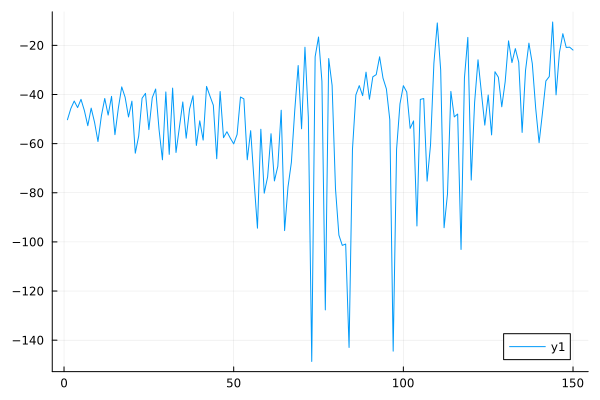

In [10]:
plot(episode_test_reward_hook.rewards)

In [11]:
close_visualization(); # closes the MeshCat visualization